<a href="https://colab.research.google.com/github/fjadidi2001/Insurance/blob/main/ClaimYNprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the dataset

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Load the dataset from Google Drive
file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


In [3]:
df.head()

,Duration,Insured.age,Insured.sex,Car.age,Marital,Car.use,Credit.score,Region,Annual.miles.drive,Years.noclaims,...,Left.turn.intensity10,Left.turn.intensity11,Left.turn.intensity12,Right.turn.intensity08,Right.turn.intensity09,Right.turn.intensity10,Right.turn.intensity11,Right.turn.intensity12,NB_Claim,AMT_Claim
0,366,45,Male,-1,Married,Commute,609.0,Urban,6213.71,25,...,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1,5100.171753
1,182,44,Female,3,Married,Commute,575.0,Urban,12427.42,20,...,58.0,24.0,11.0,1099.0,615.0,219.0,101.0,40.0,1,883.554840
2,184,48,Female,6,Married,Commute,847.0,Urban,12427.42,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000
3,183,71,Male,6,Married,Private,842.0,Urban,6213.71,43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000
4,183,84,Male,10,Married,Private,856.0,Urban,6213.71,65,...,2.0,0.0,0.0,325.0,111.0,18.0,4.0,2.0,0,0.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Duration                100000 non-null  int64  
 1   Insured.age             100000 non-null  int64  
 2   Insured.sex             100000 non-null  object 
 3   Car.age                 100000 non-null  int64  
 4   Marital                 100000 non-null  object 
 5   Car.use                 100000 non-null  object 
 6   Credit.score            100000 non-null  float64
 7   Region                  100000 non-null  object 
 8   Annual.miles.drive      100000 non-null  float64
 9   Years.noclaims          100000 non-null  int64  
 10  Territory               100000 non-null  int64  
 11  Annual.pct.driven       100000 non-null  float64
 12  Total.miles.driven      100000 non-null  float64
 13  Pct.drive.mon           100000 non-null  float64
 14  Pct.drive.tue        

# Step 2: Data Preprocessing


In [5]:
# Derive the target variable
df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)

# Drop unnecessary columns
df = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)

# Handle missing values (if any)
df = df.dropna()

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Separate features and target variable
X = df.drop('ClaimYN', axis=1)
y = df['ClaimYN']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
df.head()

,Duration,Insured.age,Car.age,Credit.score,Annual.miles.drive,Years.noclaims,Territory,Annual.pct.driven,Total.miles.driven,Pct.drive.mon,...,Right.turn.intensity10,Right.turn.intensity11,Right.turn.intensity12,ClaimYN,Insured.sex_Male,Marital_Single,Car.use_Commute,Car.use_Farmer,Car.use_Private,Region_Urban
0,366,45,-1,609.0,6213.71,25,70,0.849315,8864.376247,0.148070,...,0.0,0.0,0.0,1,True,False,True,False,False,True
1,182,44,3,575.0,12427.42,20,26,0.465753,8092.308208,0.147686,...,219.0,101.0,40.0,0,False,False,True,False,False,True
2,184,48,6,847.0,12427.42,14,84,0.520548,3225.832512,0.153735,...,0.0,0.0,0.0,0,False,False,True,False,False,True
3,183,71,6,842.0,6213.71,43,30,0.065753,253.024528,0.106702,...,0.0,0.0,0.0,0,True,False,False,False,True,True
4,183,84,10,856.0,6213.71,65,70,0.441096,4374.379634,0.123807,...,18.0,4.0,2.0,0,True,False,False,False,True,True


In [7]:
# Access the 'ClaimYN' column from the DataFrame 'df'
df['ClaimYN'].describe()  # Use .describe() for distribution statistics

# Or, if you want the ClaimYN Series:
ClaimYN_series = df['ClaimYN']
ClaimYN_series.describe()

,ClaimYN
count,100000.000000
mean,0.026980
std,0.162026
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


# Step 3: Handle Class Imbalance


In [10]:
# Use SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Display class distribution after SMOTE
print("Class distribution after SMOTE:")
print(y_resampled.value_counts())


Class distribution after SMOTE:
ClaimYN
1    97302
0    97302
Name: count, dtype: int64


# Step 4: Create the model

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Create a Gradient Boosting model (alternative to XGBoost)
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Create a Neural Network model (alternative to TabNet)
nn_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

# Train both models
gb_model.fit(X_train, y_train)
nn_model.fit(X_train, y_train)

# Make predictions using both models
gb_pred_proba = gb_model.predict_proba(X_test)[:, 1]
nn_pred_proba = nn_model.predict_proba(X_test)[:, 1]

# Combine predictions (simple average ensemble)
ensemble_pred_proba = (gb_pred_proba + nn_pred_proba) / 2
ensemble_predictions = (ensemble_pred_proba > 0.5).astype(int)



Gradient Boosting Performance Metrics:
Accuracy: 0.9561
Precision: 0.9597
Recall: 0.9528
F1 Score: 0.9562
AUC-ROC: 0.9919

Neural Network Performance Metrics:
Accuracy: 0.9847
Precision: 0.9741
Recall: 0.9960
F1 Score: 0.9849
AUC-ROC: 0.9941

Ensemble Performance Metrics:
Accuracy: 0.9876
Precision: 0.9780
Recall: 0.9978
F1 Score: 0.9878
AUC-ROC: 0.9991


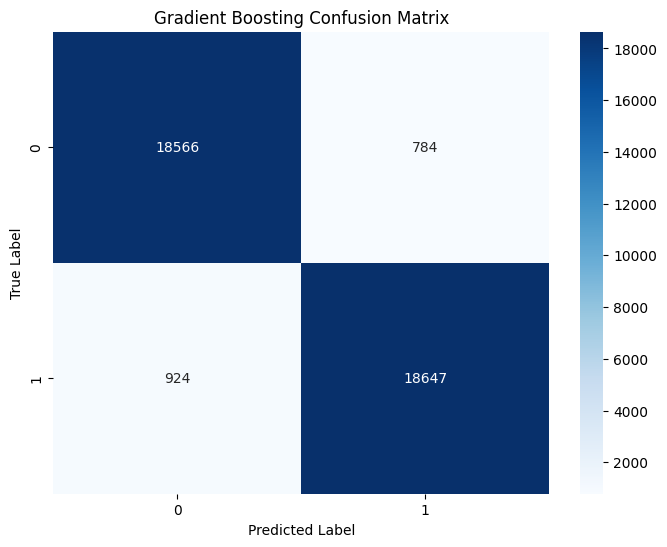

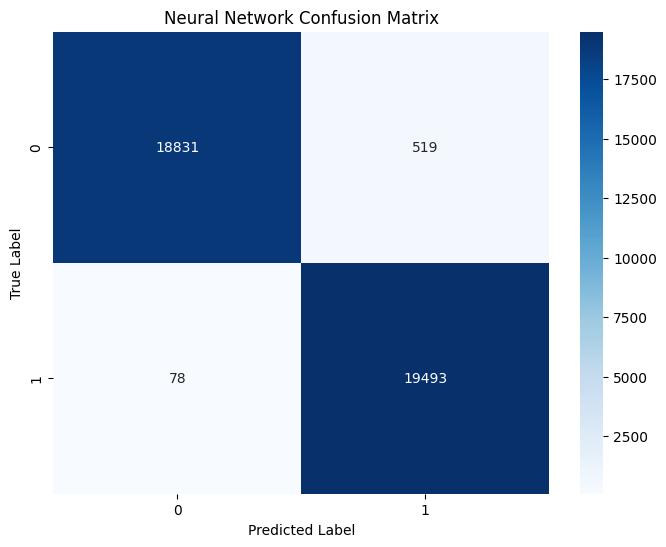

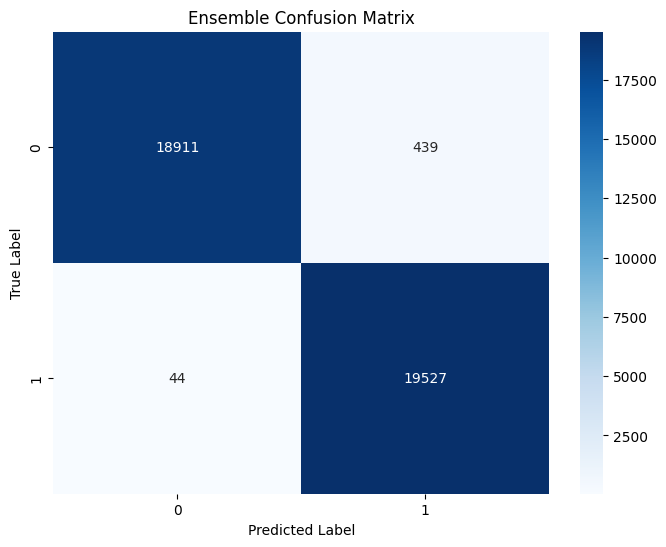

In [13]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """
    Evaluate model performance using multiple metrics
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred_proba)

    print(f"\n{model_name} Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    return accuracy, precision, recall, f1, auc_roc

def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Evaluate individual models
gb_predictions = (gb_pred_proba > 0.5).astype(int)
nn_predictions = (nn_pred_proba > 0.5).astype(int)

# Evaluate all models
evaluate_model(y_test, gb_predictions, gb_pred_proba, "Gradient Boosting")
evaluate_model(y_test, nn_predictions, nn_pred_proba, "Neural Network")
evaluate_model(y_test, ensemble_predictions, ensemble_pred_proba, "Ensemble")

# Plot confusion matrices
plot_confusion_matrix(y_test, gb_predictions, "Gradient Boosting")
plot_confusion_matrix(y_test, nn_predictions, "Neural Network")
plot_confusion_matrix(y_test, ensemble_predictions, "Ensemble")



In [ ]:
import numpy as np

class DecisionTreeRegressor:
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def _calculate_leaf_value(self, y):
        return np.mean(y)

    def _calculate_mse(self, y):
        return np.mean((y - np.mean(y)) ** 2)

    def _find_best_split(self, X, y):
        best_split = {'feature_idx': None, 'threshold': None, 'mse': float('inf')}

        for feature_idx in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_idx])

            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask

                if np.sum(left_mask) < self.min_samples_split or np.sum(right_mask) < self.min_samples_split:
                    continue

                mse = (np.sum(left_mask) * self._calculate_mse(y[left_mask]) +
                      np.sum(right_mask) * self._calculate_mse(y[right_mask])) / len(y)

                if mse < best_split['mse']:
                    best_split = {
                        'feature_idx': feature_idx,
                        'threshold': threshold,
                        'mse': mse
                    }

        return best_split

    def _build_tree(self, X, y, depth=0):
        n_samples = len(y)

        if (depth >= self.max_depth or
            n_samples < self.min_samples_split or
            len(np.unique(y)) == 1):
            return {'leaf_value': self._calculate_leaf_value(y)}

        best_split = self._find_best_split(X, y)

        if best_split['feature_idx'] is None:
            return {'leaf_value': self._calculate_leaf_value(y)}

        left_mask = X[:, best_split['feature_idx']] <= best_split['threshold']
        right_mask = ~left_mask

        left_tree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_tree = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return {
            'feature_idx': best_split['feature_idx'],
            'threshold': best_split['threshold'],
            'left': left_tree,
            'right': right_tree
        }

    def _predict_single(self, x, tree):
        if 'leaf_value' in tree:
            return tree['leaf_value']

        if x[tree['feature_idx']] <= tree['threshold']:
            return self._predict_single(x, tree['left'])
        return self._predict_single(x, tree['right'])

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)
        return self

    def predict(self, X):
        return np.array([self._predict_single(x, self.tree) for x in X])

class CustomGradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.initial_prediction = None

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _negative_gradient(self, y_true, y_pred):
        """Calculate negative gradient for logistic loss"""
        return y_true - self._sigmoid(y_pred)

    def fit(self, X, y):
        # Initialize predictions with log odds of mean
        self.initial_prediction = np.log(np.mean(y) / (1 - np.mean(y)))
        F = np.full(len(y), self.initial_prediction)

        for _ in range(self.n_estimators):
            negative_gradient = self._negative_gradient(y, F)
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, negative_gradient)

            self.trees.append(tree)
            F += self.learning_rate * tree.predict(X)

        return self

    def predict_proba(self, X):
        F = np.full(len(X), self.initial_prediction)
        for tree in self.trees:
            F += self.learning_rate * tree.predict(X)
        return self._sigmoid(F)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

class CustomNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, max_epochs=1000):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.weights = []
        self.biases = []
        self._initialize_parameters()

    def _initialize_parameters(self):
        for i in range(len(self.layer_sizes) - 1):
            self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i]))
            self.biases.append(np.zeros((1, self.layer_sizes[i+1])))

    def _relu(self, X):
        return np.maximum(0, X)

    def _relu_derivative(self, X):
        return X > 0

    def _sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

    def _sigmoid_derivative(self, X):
        s = self._sigmoid(X)
        return s * (1 - s)

    def _forward_propagation(self, X):
        activations = [X]
        for i in range(len(self.weights)):
            Z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            if i == len(self.weights) - 1:
                A = self._sigmoid(Z)  # Output layer
            else:
                A = self._relu(Z)     # Hidden layers
            activations.append(A)
        return activations

    def _backward_propagation(self, X, y, activations):
        m = X.shape[0]
        dZ = activations[-1] - y.reshape(-1, 1)
        gradients = {'dW': [], 'db': []}

        for i in reversed(range(len(self.weights))):
            gradients['dW'].insert(0, np.dot(activations[i].T, dZ) / m)
            gradients['db'].insert(0, np.sum(dZ, axis=0, keepdims=True) / m)

            if i > 0:
                dA = np.dot(dZ, self.weights[i].T)
                dZ = dA * self._relu_derivative(activations[i])

        return gradients

    def fit(self, X, y):
        for _ in range(self.max_epochs):
            # Forward propagation
            activations = self._forward_propagation(X)

            # Backward propagation
            gradients = self._backward_propagation(X, y, activations)

            # Update parameters
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * gradients['dW'][i]
                self.biases[i] -= self.learning_rate * gradients['db'][i]

    def predict_proba(self, X):
        return self._forward_propagation(X)[-1]

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

class CustomEnsemble:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, nn_layers=[100, 50, 1]):
        self.gb_model = CustomGradientBoosting(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth
        )
        input_size = None  # Will be set during fitting
        self.nn_model = CustomNeuralNetwork(
            layer_sizes=[input_size] + nn_layers if input_size else None,
            learning_rate=0.01,
            max_epochs=1000
        )

    def fit(self, X, y):
        # Update neural network input size
        if self.nn_model.layer_sizes is None:
            input_size = X.shape[1]
            self.nn_model = CustomNeuralNetwork(
                layer_sizes=[input_size, 100, 50, 1],
                learning_rate=0.01,
                max_epochs=1000
            )

        # Train both models
        self.gb_model.fit(X, y)
        self.nn_model.fit(X, y)
        return self

    def predict_proba(self, X):
        gb_pred = self.gb_model.predict_proba(X)
        nn_pred = self.nn_model.predict_proba(X)
        return (gb_pred + nn_pred) / 2

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

# Usage example:
def train_and_evaluate_custom_model(X_train, X_test, y_train, y_test):
    # Create and train the ensemble
    model = CustomEnsemble(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        nn_layers=[100, 50, 1]
    )
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_test)

    # Calculate precision
    true_positives = np.sum((y_pred == 1) & (y_test == 1))
    predicted_positives = np.sum(y_pred == 1)
    precision = true_positives / predicted_positives if predicted_positives > 0 else 0

    # Calculate recall
    actual_positives = np.sum(y_test == 1)
    recall = true_positives / actual_positives if actual_positives > 0 else 0

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return model

In [ ]:
# Create and train the model
model = CustomEnsemble(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    nn_layers=[X_train.shape[1], 100, 50, 1]
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)